In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df = pd.read_excel("../Hackathon/df_limpio2.xlsx")

In [55]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Estadística descriptiva

**Métricas descriptivas**

In [56]:
df.describe()

,Creacion Orden de Venta,Cantidad
count,26199,26199.000000
mean,2022-06-22 18:31:32.133287424,405.210695
min,2021-01-04 00:00:00,0.000000
25%,2021-09-22 00:00:00,22.000000
50%,2022-06-20 00:00:00,72.000000
75%,2023-03-22 00:00:00,300.000000
max,2023-12-29 00:00:00,37800.000000
std,NaN,1156.697059


### Pruebas ANOVA

- Hipótesis Nula (H0): No hay diferencias significativas en la 'Cantidad' vendida entre las diferentes categorías de la variable categórica.
- Hipótesis Alternativa (H1): Existen diferencias significativas en la 'Cantidad' vendida entre las diferentes categorías de la variable categórica.

In [57]:
# Realizar ANOVA para la variable 'Artículo'
model = ols('Cantidad ~ C(Articulo)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                   sum_sq       df          F  PR(>F)
C(Articulo)  1.546747e+10    888.0  22.511002     0.0
Residual     1.958410e+10  25310.0        NaN     NaN


El tipo de artículo que se vende tiene un impacto significativo en la cantidad vendida. Los diferentes artículos que se venden no se venden en las mismas cantidades. Hay artículos que se venden significativamente más que otros. 
El p-value es mucho menor que el nivel de significancia común de 0.05. Esto significa que hay evidencia estadística muy fuerte para rechazar la hipótesis nula. 

In [58]:
# Renombra la columna
df = df.rename(columns={'Codigo Cliente': 'CodigoCliente'})

In [59]:
# ANOVA Codigo Cliente 
model = ols('Cantidad ~ C(CodigoCliente)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                        sum_sq       df         F  PR(>F)
C(CodigoCliente)  8.965789e+09    906.0  9.594884     0.0
Residual          2.608578e+10  25292.0       NaN     NaN


Existen diferencias estadísticamente significativas en la 'Cantidad' vendida entre los diferentes códigos de cliente: el código de cliente tiene un impacto significativo en la cantidad vendida. Los diferentes clientes no compran las mismas cantidades de productos. Hay clientes que compran significativamente más que otros. El codigo de cliente tiene un efecto mucho mayor en la cantidad vendida, que el articulo. 

In [60]:
# Renombra la columna
df = df.rename(columns={'Unidad de venta': 'UnidadVenta'})

In [61]:
# Realizar ANOVA para la variable 'Unidad de venta'
model = ols('Cantidad ~ C(UnidadVenta)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                      sum_sq       df           F         PR(>F)
C(UnidadVenta)  1.291216e+09      2.0  500.952949  3.135064e-214
Residual        3.376035e+10  26196.0         NaN            NaN


El p-value es muy pequeño, mucho menor que 0.05. Esto indica que hay evidencia estadística extremadamente fuerte para rechazar la hipótesis nula.Existen diferenciassignificativas en la 'Cantidad' vendida entre las diferentes unidades de venta: la unidad de venta tiene un impacto significativo en la cantidad vendida. Las diferentes unidades de venta influyen significativamente en la cantidad de producto vendido.

In [62]:
# Obtener los 5 productos más vendidos
top_products = df.groupby('Articulo')['Cantidad'].sum().nlargest(5).index
df_top = df[df['Articulo'].isin(top_products)]

In [63]:
top_products

Index(['IVP07099', 'IVP07094', 'IVP09009', 'IVP07452', 'IVP07384'], dtype='object', name='Articulo')

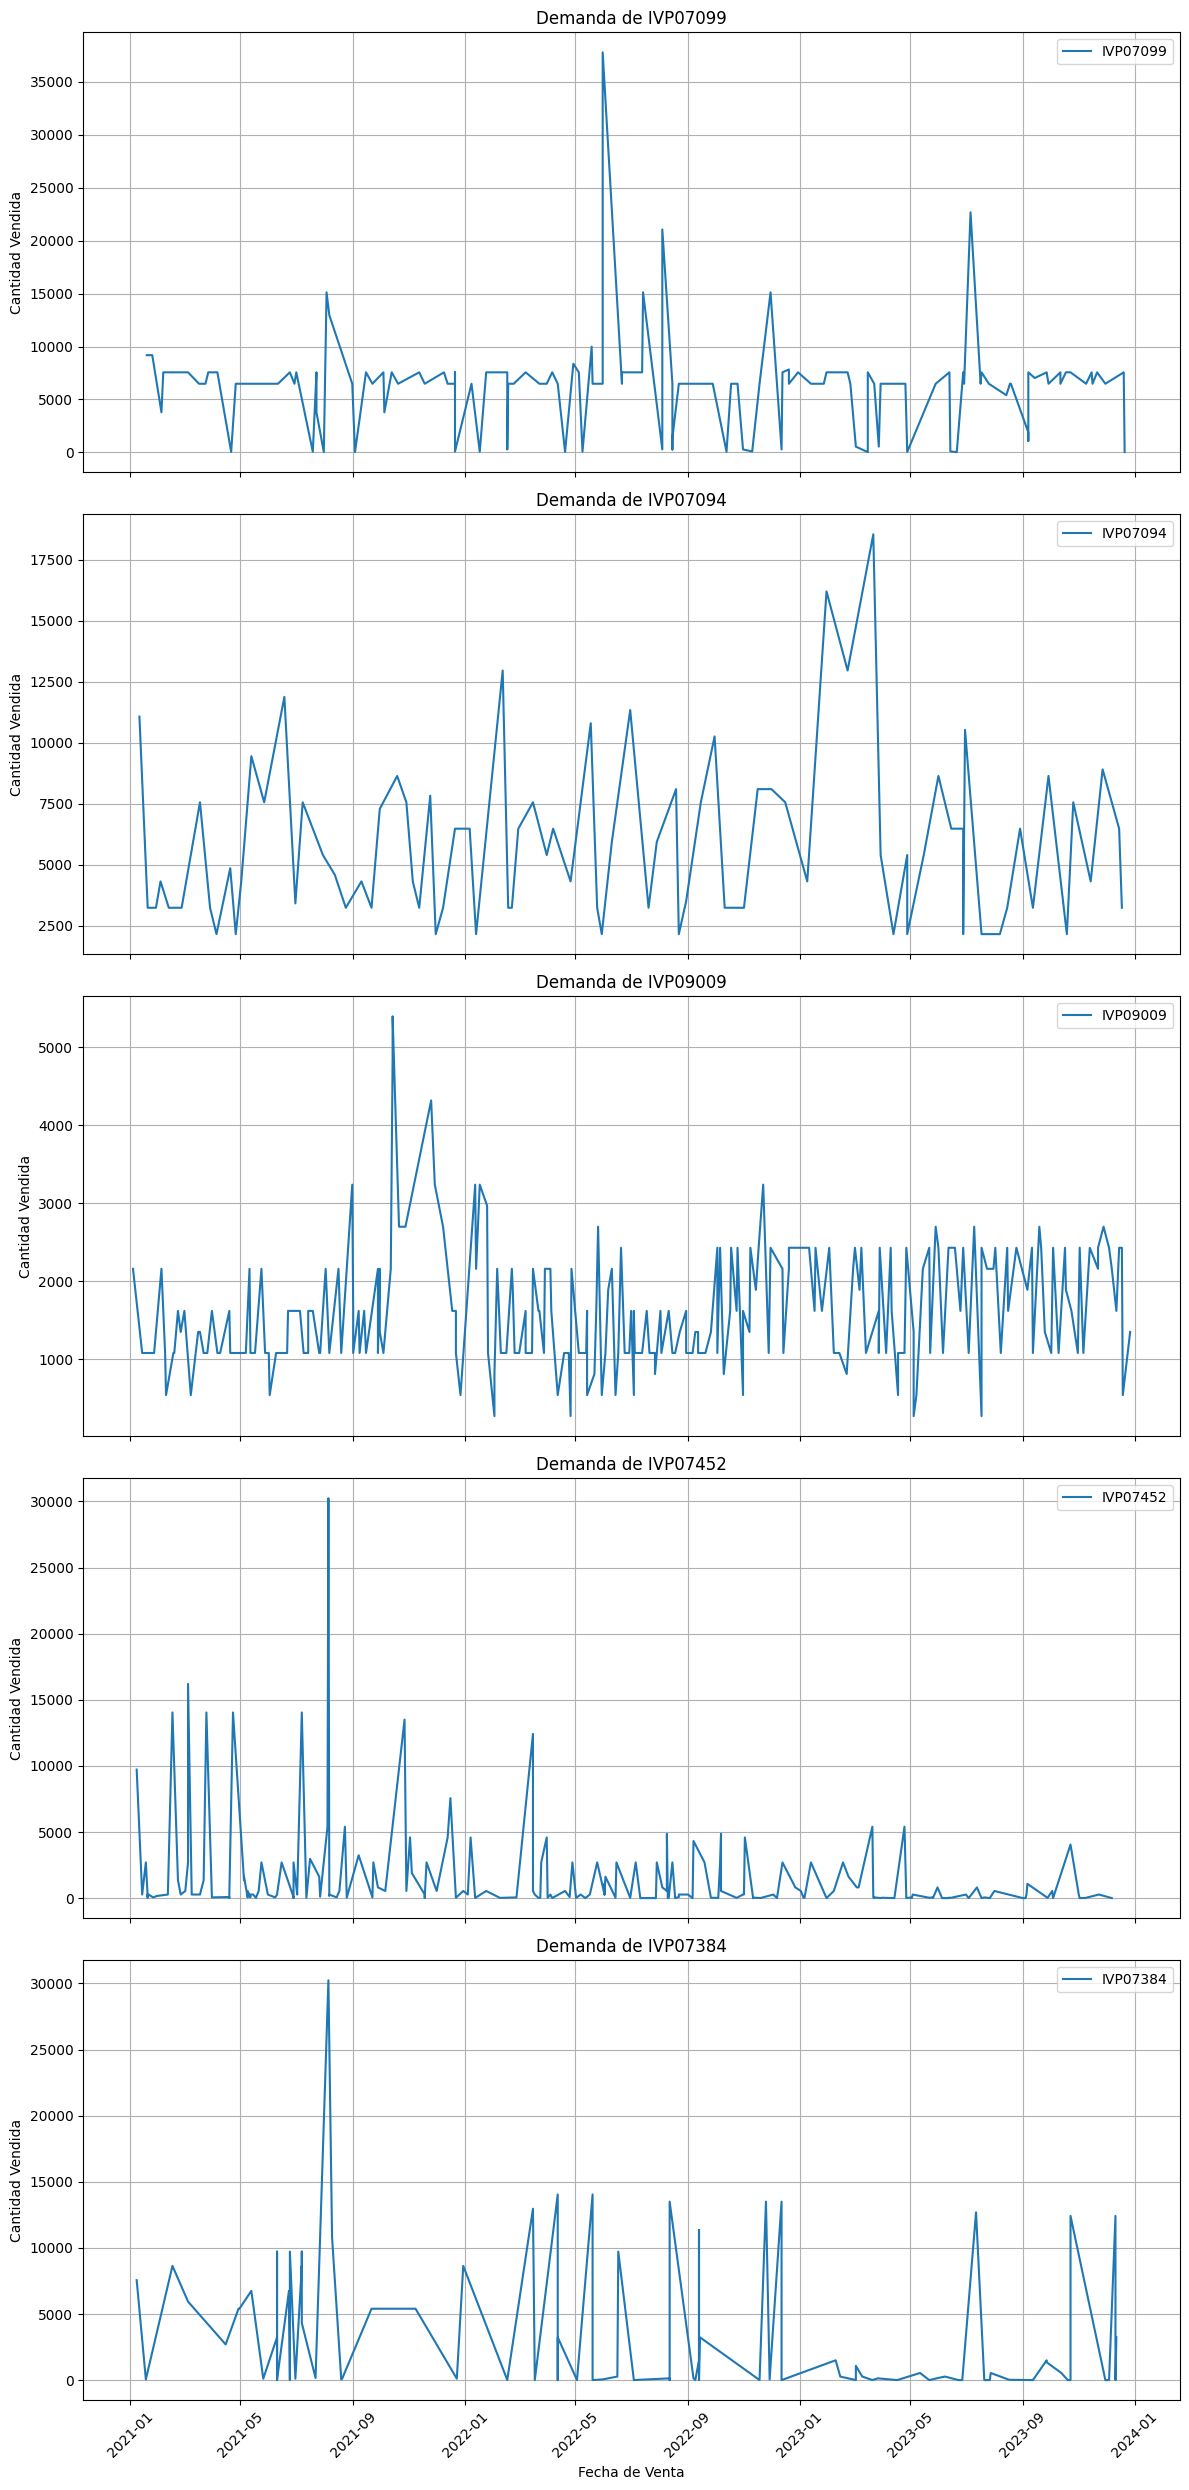

In [64]:
fig, axes = plt.subplots(nrows=len(top_products), ncols=1, figsize=(12, 5 * len(top_products)), sharex=True)

if len(top_products) == 1:
    axes = [axes]  

for ax, product in zip(axes, top_products):
    data = df_top[df_top['Articulo'] == product]
    ax.plot(data['Creacion Orden de Venta'], data['Cantidad'], label=product)
    ax.set_title(f"Demanda de {product}")
    ax.set_ylabel('Cantidad Vendida')
    ax.legend()
    ax.grid()

plt.xlabel('Fecha de Venta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Los artículos más vendidos: 'IVP07099', 'IVP07094', 'IVP09009', 'IVP07452', 'IVP07384'. Son los que predeciremos.

Los 5 clientes que más compran son: 'F6F39D95', '68F46D1A', 'A319D1B7', '1C110892', '9F2A92E3'

- el producto que más compra cada cliente 

### Pruebas de estacionalidad 

Checar si las series de tiempo son estacionarias o no. 
- H0: Tiene propiedades estadísticas constantes a lo largo del tiempo, su media y varianza no cambian. 
- H1: Tiene características de media, varianza y covarianza que cambian a lo largo del tiempo. 

In [65]:
from statsmodels.tsa.stattools import adfuller

# Convertir la columna 'Creacion Orden de Venta' a datetime
df['Creacion Orden de Venta'] = pd.to_datetime(df['Creacion Orden de Venta'])

# Agrupar los datos por 'Creacion Orden de Venta' y 'Articulo' y calcular la suma de 'Cantidad'
df_grouped = df.groupby(['Creacion Orden de Venta', 'Articulo'])['Cantidad'].sum().reset_index()

In [66]:
# Función para realizar la prueba ADF y mostrar los resultados
def test_stationarity(timeseries, articulo):
    print(f'Resultados de la prueba ADF para el artículo: {articulo}')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [67]:
# Obtener la lista de artículos únicos
articulos_unicos = df_grouped['Articulo'].unique()

In [69]:
# Realizar la prueba ADF para cada artículo
for articulo in top_products:
    timeseries_articulo = df_grouped[df_grouped['Articulo'] == articulo].set_index('Creacion Orden de Venta')['Cantidad']
    test_stationarity(timeseries_articulo, articulo)

Resultados de la prueba ADF para el artículo: IVP07099
Test Statistic                -9.488095e+00
p-value                        3.715640e-16
#Lags Used                     0.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64
Resultados de la prueba ADF para el artículo: IVP07094
Test Statistic                -8.319708e+00
p-value                        3.600139e-13
#Lags Used                     0.000000e+00
Number of Observations Used    8.500000e+01
Critical Value (1%)           -3.509736e+00
Critical Value (5%)           -2.896195e+00
Critical Value (10%)          -2.585258e+00
dtype: float64
Resultados de la prueba ADF para el artículo: IVP09009
Test Statistic                  -4.955656
p-value                          0.000027
#Lags Used                       3.000000
Number of Observations Used    223.000000
Critical Value (1%)  

In [ ]:
# Realizar la prueba ADF para cada artículo
for articulo in articulos_unicos:
    timeseries_articulo = df_grouped[df_grouped['Articulo'] == articulo].set_index('Creacion Orden de Venta')['Cantidad']
    test_stationarity(timeseries_articulo, articulo)

Resultados de la prueba ADF para el artículo: IVP01010
Test Statistic                -5.928505e+00
p-value                        2.411614e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+01
Critical Value (1%)           -3.632743e+00
Critical Value (5%)           -2.948510e+00
Critical Value (10%)          -2.613017e+00
dtype: float64
Resultados de la prueba ADF para el artículo: IVP04039
Test Statistic                  -3.965300
p-value                          0.001604
#Lags Used                      10.000000
Number of Observations Used    620.000000
Critical Value (1%)             -3.440941
Critical Value (5%)             -2.866213
Critical Value (10%)            -2.569259
dtype: float64
Resultados de la prueba ADF para el artículo: IVP07105
Test Statistic                 -3.368842
p-value                         0.012068
#Lags Used                      0.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.65352

ValueError: sample size is too short to use selected regression component

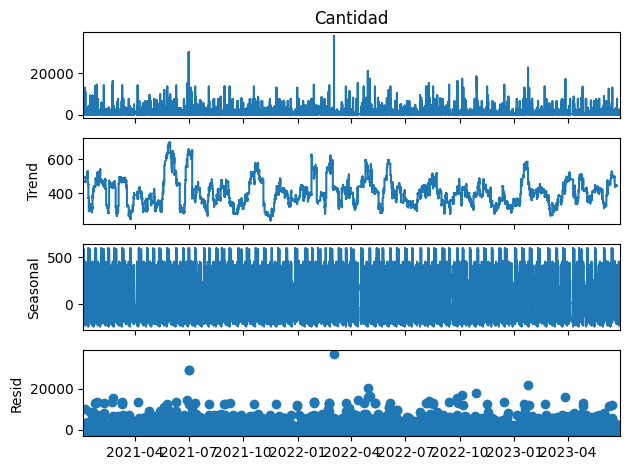

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Cargar los datos
df = pd.read_excel("../Hackathon/df.xlsx", 
                   parse_dates=['Creacion Orden de Venta'], index_col='Creacion Orden de Venta')



# Seleccionar la columna de 'Cantidad' como la serie temporal
serie = df['Cantidad']

# Eliminar los valores faltantes (NaN)
serie = serie.dropna()

# Descomposición de la serie temporal para ver los componentes (tendencia, estacionalidad, residuos)
result = seasonal_decompose(serie, model='additive', period=365)  # Usar modelo aditivo
result.plot()
plt.show()

In [48]:
# Comprobación de estacionariedad con el test de Dickey-Fuller
result_adf = adfuller(serie)
print(f'Estadístico de prueba ADF: {result_adf[0]}')
print(f'Valor p: {result_adf[1]}')

Estadístico de prueba ADF: -40.37544908777359
Valor p: 0.0


In [49]:
# Si el valor p es mayor que 0.05, la serie no es estacionaria y necesita diferenciación
if result_adf[1] > 0.05:
    print("La serie no es estacionaria, aplicando diferenciación.")
    serie_diff = serie.diff().dropna()  # Aplicar diferenciación
    # Graficar la serie diferenciada
    plt.figure(figsize=(10,6))
    plt.plot(serie_diff)
    plt.title('Serie Diferenciada')
    plt.show()
else:
    print("La serie es estacionaria.")

La serie es estacionaria.


Estadístico de prueba ADF: -40.37544908777359
Este es el valor del estadístico de prueba calculado por la prueba ADF. Cuanto más negativo sea este valor, más fuerte es la evidencia contra la hipótesis nula de que la serie tiene una raíz unitaria (es decir, que no es estacionaria).

**Interpretación de la gráfica**

- La serie temporal muestra una fuerte estacionalidad, como se evidencia en el patrón repetitivo en el componente "Seasonal".
- La tendencia muestra una fluctuación gradual a lo largo del tiempo.
- Los residuos son relativamente aleatorios, con algunos valores atípicos.
- Esta descomposición sugiere que un modelo que capture la tendencia y la estacionalidad sería apropiado para modelar y pronosticar esta serie temporal.
- Se observa que hay muchos datos atípicos, por lo cual, al hacer predicciones, hay que tener cuidado.

In [70]:
# Leer los datos desde el archivo Excel
df = pd.read_excel("../Hackathon/df_limpio2.xlsx")


In [53]:
df["Cantidad"].var()

np.float64(1337948.0874480205)

### análisis acf y pacf

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Renombrar columnas para facilidad
df.rename(columns={"Creacion Orden de Venta": "fecha_orden", "Articulo": "id_producto", "Cantidad": "cantidad_vendida"}, inplace=True)


In [72]:
# Asegurar que la columna de fecha está en formato datetime
df["fecha_orden"] = pd.to_datetime(df["fecha_orden"])

In [73]:
# Agrupar por producto y fecha, sumando la cantidad vendida
df_grouped = df.groupby(["id_producto", "fecha_orden"]).agg({"cantidad_vendida": "sum"}).reset_index()

# Seleccionar un producto específico para el análisis
producto_id = df_grouped["id_producto"].iloc[0]  # Tomar el primer producto disponible como ejemplo
df_producto = df_grouped[df_grouped["id_producto"] == producto_id].set_index("fecha_orden")

In [75]:
print(len(df_producto["cantidad_vendida"]))


1


In [76]:
print(df.head())  # Ver los primeros registros
print(df["cantidad_vendida"].describe())  # Ver estadísticas generales


  Orden de Venta fecha_orden Codigo Cliente id_producto  cantidad_vendida  \
0      ABC063830  2021-01-04       F26E901B    IVP11576                60   
1      ABC063832  2021-01-04       12558C43    IVP07229               540   
2      ABC063833  2021-01-04       A760F354    IVP04039                 3   
3      ABC063834  2021-01-04       A760F354    IVP04039                 4   
4      ABC063835  2021-01-04       A760F354    IVP01010                 1   

  Unidad de venta  
0               L  
1              KG  
2             PZA  
3             PZA  
4             PZA  
count    26199.000000
mean       405.210695
std       1156.697059
min          0.000000
25%         22.000000
50%         72.000000
75%        300.000000
max      37800.000000
Name: cantidad_vendida, dtype: float64


In [ ]:
# Graficar ACF y PACF
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(121)
plot_acf(df_producto["cantidad_vendida"], lags=40, ax=plt.gca())
plt.title(f'ACF del producto {producto_id}')

# PACF
plt.subplot(122)
plot_pacf(df_producto["cantidad_vendida"], lags=40, ax=plt.gca())
plt.title(f'PACF del producto {producto_id}')

plt.tight_layout()
plt.show()

In [ ]:


# Mostrar las primeras filas para revisar
df.head()


,Orden de Venta,Creacion Orden de Venta,Codigo Cliente,Articulo,Cantidad,Unidad de venta
0,ABC063830,2021-01-04,F26E901B,IVP11576,60,L
1,ABC063832,2021-01-04,12558C43,IVP07229,540,KG
2,ABC063833,2021-01-04,A760F354,IVP04039,3,PZA
3,ABC063834,2021-01-04,A760F354,IVP04039,4,PZA
4,ABC063835,2021-01-04,A760F354,IVP01010,1,PZA


### Modelo SARIMA

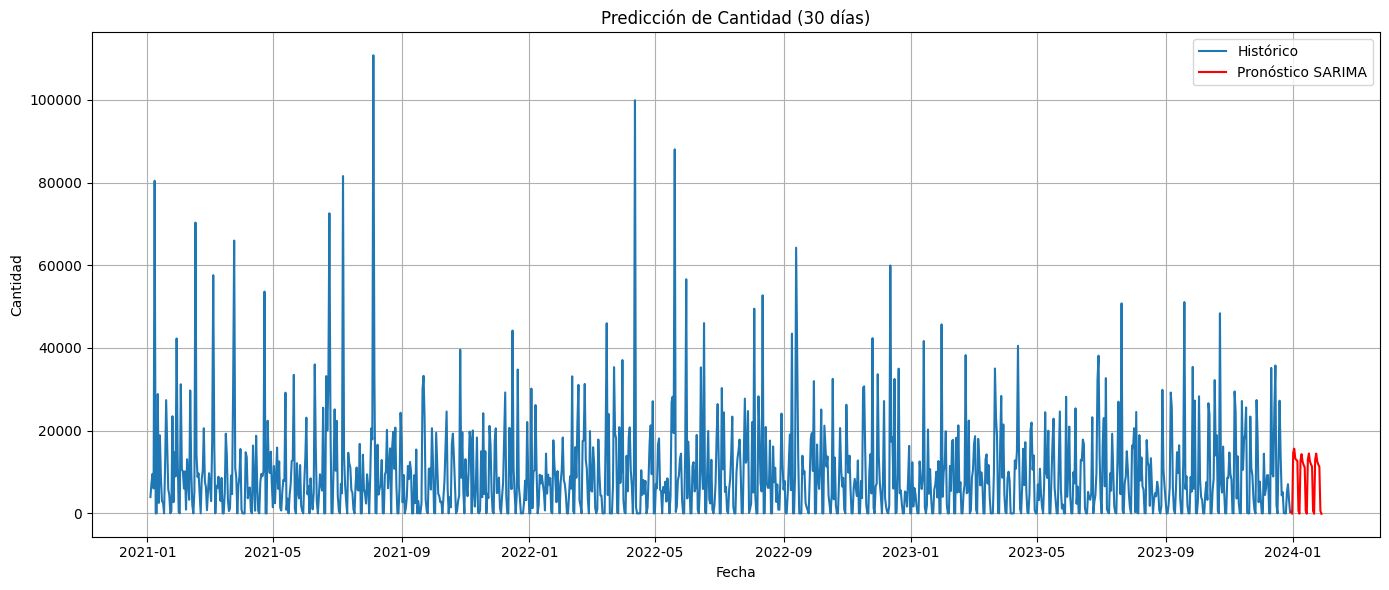

In [1]:
import pandas as pd

# Cargar el archivo Excel
file_path = "../Hackathon/df_limpio2.xlsx"

df = pd.read_excel(file_path)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Asegurarnos de que la fecha esté en formato datetime
df['Creacion Orden de Venta'] = pd.to_datetime(df['Creacion Orden de Venta'])

# Agrupar por fecha y sumar la cantidad para obtener una serie temporal diaria
ts = df.groupby('Creacion Orden de Venta')['Cantidad'].sum()

# Asegurar frecuencia diaria
ts = ts.asfreq('D').fillna(0)

# Entrenar modelo SARIMA
model = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=False)

# Predecir los próximos 30 días
forecast = results.get_forecast(steps=30)
forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Graficar resultados
plt.figure(figsize=(14, 6))
plt.plot(ts, label='Histórico')
plt.plot(forecast_series, label='Pronóstico SARIMA', color='red')
plt.title('Predicción de Cantidad (30 días)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Time series cross-validation

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Crear función para time series cross-validation con SARIMA
def time_series_cv(data, order, seasonal_order, n_splits=5, forecast_horizon=7):
    split_size = len(data) // (n_splits + 1)
    errors = []

    for i in range(n_splits):
        train_end = (i + 1) * split_size
        train = data[:train_end]
        test = data[train_end:train_end + forecast_horizon]

        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

        forecast = results.forecast(steps=forecast_horizon)
        error = sqrt(mean_squared_error(test, forecast))
        errors.append(error)

    return errors

# Ejecutar validación cruzada temporal
cv_errors = time_series_cv(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), n_splits=5, forecast_horizon=7)

cv_errors, np.mean(cv_errors)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


([26278.684741709483,
  11582.86997531515,
  10091.363036880899,
  7176.130435526607,
  12576.283825799213],
 np.float64(13541.06640304627))

**Resultado**

Errores para los 5 folds: [26278.68, 11582.88, 10091.36, 7213.04, 12556.47]
Promedio: 13,544.49 (RMSE promedio)
El error baja en algunos folds: el modelo mejora conforme avanza en el tiempo, probablemente porque tiene más datos para entrenarse en los folds posteriores. Puede haber habido más ruido, irregularidades o cambios de comportamiento al inicio de la serie.
El modelo SARIMA es consistente, mejora en los últimos folds y muestra buen desempeño relativo. El RMSE promedio de ~13,544 quiere decir que, en general, el modelo se equivoca por alrededor de 13,500 unidades en la predicción semanal. 



**Grid search para encontrar los mejores hiperparámetros: modelo SARIMAX**

In [2]:
# Reimportar e instalar dependencias tras reinicio del entorno
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Cargar el archivo de nuevo
file_path = "../Hackathon/df_limpio2.xlsx"
df = pd.read_excel(file_path)

# Procesar la columna de fechas y serie temporal diaria
df['Creacion Orden de Venta'] = pd.to_datetime(df['Creacion Orden de Venta'])
ts = df.groupby('Creacion Orden de Venta')['Cantidad'].sum().asfreq('D').fillna(0)

# Búsqueda de parámetros manual con grid search limitado
results_summary = []
best_rmse = float("inf")
best_cfg = None
best_model = None

# Grid simple
for p in range(0, 2):
    for d in range(1, 2):
        for q in range(0, 2):
            for P in range(0, 2):
                for D in range(1, 2):
                    for Q in range(0, 2):
                        try:
                            model = SARIMAX(ts,
                                            order=(p, d, q),
                                            seasonal_order=(P, D, Q, 7),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            result = model.fit(disp=False)
                            pred = result.predict(start=len(ts)-30, end=len(ts)-1)
                            rmse = np.sqrt(mean_squared_error(ts[-30:], pred))
                            results_summary.append(((p, d, q), (P, D, Q, 7), rmse))
                            if rmse < best_rmse:
                                best_rmse = rmse
                                best_cfg = ((p, d, q), (P, D, Q, 7))
                                best_model = result
                        except:
                            continue

best_cfg, best_rmse


(((1, 1, 1), (0, 1, 1, 7)), np.float64(8912.927431031812))

**Resultados**

order = (1, 1, 1)

seasonal_order = (0, 1, 1, 7) ← (estacionalidad semanal)

RMSE = 8,912.93

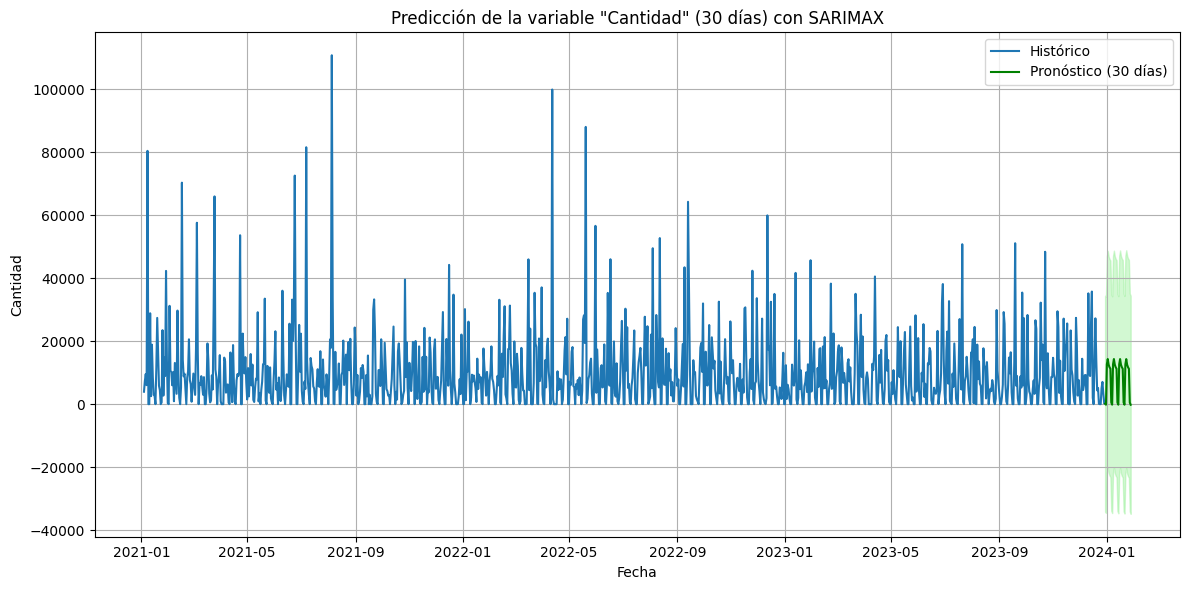

In [ ]:
# Predicción de los próximos 30 días
forecast = best_model.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
lower_ci = forecast_ci.iloc[:, 0].astype(float).values
upper_ci = forecast_ci.iloc[:, 1].astype(float).values

# Gráfica del resultado
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Histórico')
plt.plot(forecast_index, forecast_mean, label='Pronóstico (30 días)', color='green')
plt.fill_between(forecast_index, lower_ci, upper_ci, color='lightgreen', alpha=0.4)
plt.title('Predicción de la variable "Cantidad" (30 días) con SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Aunque hay mucha variabilidad, no se observa una tendencia fuerte creciente o decreciente a largo plazo. El modelo SARIMAX ajusta la estacionalidad semanal (periodicidad = 7) y reproduce ese patrón en la predicción. El modelo predice que la variable "Cantidad" se mantendrá dentro de rangos similares al pasado reciente, pero con cierta incertidumbre (amplitud de las bandas de confianza). En el pasado hay picos extremos, pero el modelo no los proyecta en el futuro. Este modelo no considera valores atípicos como recurrentes, prioriza la tendencia y estacionalidad promedio, no los outliers.

In [4]:
from sklearn.model_selection import TimeSeriesSplit

# Configuración de validación cruzada para series de tiempo
n_splits = 5
horizon = 30  # pasos a predecir en cada validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Guardar los errores de cada validación
rmse_scores = []

# Convertir serie a array (por si el index da problemas en slicing)
ts_values = ts.values

# Cross-validation manual
for train_index, test_index in tscv.split(ts_values):
    train, test = ts_values[train_index], ts_values[test_index]

    if len(test) < horizon:
        continue  # nos aseguramos de tener suficientes pasos para evaluar

    try:
        # Ajustar modelo al set de entrenamiento
        model_cv = SARIMAX(train,
                           order=best_cfg[0],
                           seasonal_order=best_cfg[1],
                           enforce_stationarity=False,
                           enforce_invertibility=False)
        result_cv = model_cv.fit(disp=False)

        # Predecir horizonte
        pred_cv = result_cv.predict(start=len(train), end=len(train) + horizon - 1)

        # Calcular error
        actual = test[:horizon]
        rmse = np.sqrt(mean_squared_error(actual, pred_cv))
        rmse_scores.append(rmse)
    except:
        continue

rmse_scores


[np.float64(19707.025764999555),
 np.float64(5941.300908324468),
 np.float64(6523.171932520464),
 np.float64(10180.762415545218),
 np.float64(9697.558609689007)]

El error varía entre folds, lo que indica que el comportamiento de la serie no es completamente homogéneo en el tiempo (hay cambios en la varianza o patrones).El primer fold tiene un RMSE alto porque probablemente abarca un periodo con picos atípicos. Los demás errores son más estables y en promedio moderados, lo que sugiere que el modelo generaliza relativamente bien.



